# Evaluate a trained model

Setup for tqdm widgets: https://ipywidgets.readthedocs.io/en/stable/user_install.html#installing-the-jupyterlab-extension

In [108]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import pickle
import shutil
import sys
from typing import List

import azureml.core
from azureml.core import Experiment, Workspace
from azureml.core.dataset import Dataset
from azureml.core.run import Run
import glob2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.models import load_model
from tqdm.notebook import tqdm
from IPython.display import display, HTML

print("Azure ML SDK Version: ", azureml.core.VERSION)

sys.path.append(str(Path(os.getcwd()).parent / 'src'))
from eval_utils import calculate_performance, CODE_TO_SCANTYPE, CONFIG, MODEL_CKPT_FILENAME, REPO_DIR, preprocess_targets, preprocess_depthmap, tf_load_pickle, preprocess, extract_qrcode, extract_scantype, avgerror

latefusion_path = 'src/models/CNNDepthMap/CNNDepthMap-height/q3-depthmapmultiartifactlatefusion-plaincnn-height/src'
sys.path.append(str(REPO_DIR / latefusion_path))
sys.path.append(str(REPO_DIR / 'src/common/model_utils'))
from preprocessing import create_multiartifact_paths, create_samples
from preprocessing_multiartifact import create_multiartifact_sample

Azure ML SDK Version:  1.18.0


In [109]:
print(REPO_DIR)
DATA_DIR = REPO_DIR / 'data' if Run.get_context().id.startswith("OfflineRun") else Path(".")
print(DATA_DIR)

/mnt/resource/batch/tasks/shared/LS_root/mounts/clusters/mhinsche-cpu/code/Users/mhinsche/cgm-ml
/mnt/resource/batch/tasks/shared/LS_root/mounts/clusters/mhinsche-cpu/code/Users/mhinsche/cgm-ml/data


### Select the  model to be evaluated from workspace

In [110]:
workspace = Workspace.from_config()

# RUN_ID = 'q3-depthmapmultiartifactlatefusion-plaincnn-height-95k_1614066635_8c470f0a'
# RUN_NUMBER = 4

RUN_ID = 'q3-depthmapmultiartifactlatefusion-plaincnn-height-95k_1614177517_ecd7b6e2'
RUN_NUMBER = 6


EXPERIMENT = "_".join(RUN_ID.split('_')[:-2])
OUTPUT_DIR = f'data/logs/q3-depthmapmultiartifact-plaincnn-height-95k/run_{RUN_NUMBER}/'

### Download the models on your local system for evaluation

In [111]:
# Download model
print(f"Downloading model from {RUN_ID}")
previous_experiment = Experiment(workspace=workspace, name=EXPERIMENT)
previous_run = Run(previous_experiment, RUN_ID)
model_fpath = DATA_DIR / "pretrained" / RUN_ID
previous_run.download_files(f"outputs/{MODEL_CKPT_FILENAME}", model_fpath)

In [112]:
# Debug with local model
# model_fpath = DATA_DIR / 'outputs' / MODEL_CKPT_FILENAME

### Load the models

In [113]:
model_fpath

PosixPath('/mnt/resource/batch/tasks/shared/LS_root/mounts/clusters/mhinsche-cpu/code/Users/mhinsche/cgm-ml/data/pretrained/q3-depthmapmultiartifactlatefusion-plaincnn-height-95k_1614177517_ecd7b6e2')

In [114]:
model = load_model(f'{model_fpath}/outputs/{MODEL_CKPT_FILENAME}')
# summarize model.
# model.summary()

### Show a sample from the testset

In [115]:
# Clean: anon-depthmap-testset
# DATASET_DIR = DATA_DIR / "anon-depthmap-testset" / "scans"  # locally
# DATASET_DIR = Path('/mnt/datasets/depthmap_testset') / "scans"  # on VM

# Unclean: anon-realtime-testdata
# DATASET_DIR = DATA_DIR / "anon-realtime-testdata" / "depthmaps" # locally
DATASET_DIR = Path('/mnt/datasets/realtime_evaluation') / "depthmaps" # on VM

depthmap_max: 1.0


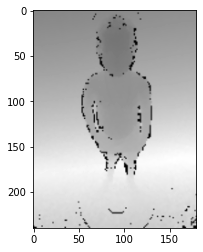

In [116]:
paths = DATASET_DIR / "1585015607-01sk32pthg/100/pc_1585015607-01sk32pthg_1591875909425_100_000.p"

depthmap, targets = pickle.load(open(paths, "rb"))
depthmap = preprocess_depthmap(depthmap)
depthmap = depthmap / depthmap.max()
print("depthmap_max:", depthmap.max())
depthmap = tf.image.resize(depthmap, (CONFIG.IMAGE_TARGET_HEIGHT, CONFIG.IMAGE_TARGET_WIDTH))
targets = preprocess_targets(targets, CONFIG.TARGET_INDEXES)
depthmap.set_shape((CONFIG.IMAGE_TARGET_HEIGHT, CONFIG.IMAGE_TARGET_WIDTH, 1))
# targets.set_shape((len(targets_indices,)))
plt.imshow(np.squeeze(depthmap), cmap='gray');

## Dataset

To use the dataset, you can:
- mount the dataset
- use datastore (blob storage)
- download the dataset

Choose your preferred way and make sure to adjust the absolute path

In [117]:
DATASET_PATH = str(DATASET_DIR / "*/")

### Perform the prediction

In [118]:
qrcode_paths = glob2.glob(DATASET_PATH); 
print(len(qrcode_paths))
qrcode_paths = qrcode_paths# [:100]  # reduce size for DEBUG speed
qrcode_paths[:3]

3000


['/mnt/datasets/realtime_evaluation/depthmaps/1585221777-nbkphm80ut',
 '/mnt/datasets/realtime_evaluation/depthmaps/1585120870-mmu6j6fyir',
 '/mnt/datasets/realtime_evaluation/depthmaps/1583997707-txmia01gdm']

In [119]:
CONFIG.CODES_FOR_POSE_AND_SCANSTEP

('100', '101', '102', '200', '201', '202')

In [ ]:
samples_paths = create_samples(qrcode_paths, CONFIG)

In [ ]:
# create_multiartifact_paths??

In [121]:
# len(samples_paths), samples_paths[0]

In [122]:
predictions = []
for sample_paths in tqdm(samples_paths):
    depthmap, targets = create_multiartifact_sample(sample_paths)
    depthmaps = tf.stack([depthmap])
    
    pred = model.predict(depthmaps)
    
    predictions.append([sample_paths[0], float(np.squeeze(pred)), targets[0]])

  0%|          | 0/8967 [00:00<?, ?it/s]

target_list: [array([64.3], dtype=float32), array([85.8], dtype=float32), array([85.8], dtype=float32), array([85.8], dtype=float32), array([85.8], dtype=float32)] artifacts: ['/mnt/datasets/realtime_evaluation/depthmaps/1585016399-mg9sx56znh/100/pc_1585016399-mg9sx56znh_1591886138741_100_000.p', '/mnt/datasets/realtime_evaluation/depthmaps/1585016399-mg9sx56znh/100/pc_1585016399-mg9sx56znh_1591886138741_100_001.p', '/mnt/datasets/realtime_evaluation/depthmaps/1585016399-mg9sx56znh/100/pc_1585016399-mg9sx56znh_1591886138741_100_002.p', '/mnt/datasets/realtime_evaluation/depthmaps/1585016399-mg9sx56znh/100/pc_1585016399-mg9sx56znh_1591886138741_100_003.p', '/mnt/datasets/realtime_evaluation/depthmaps/1585016399-mg9sx56znh/100/pc_1585016399-mg9sx56znh_1591886138741_100_004.p']
target_list: [array([85.8], dtype=float32), array([85.8], dtype=float32), array([85.8], dtype=float32), array([85.8], dtype=float32), array([64.3], dtype=float32)] artifacts: ['/mnt/datasets/realtime_evaluation/dep

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [123]:
# 4.2 minutes for all 1745 scans' predictions

predictions[0]

['/mnt/datasets/realtime_evaluation/depthmaps/1583462505-43bak4gvfa/100/pc_1583462505-43bak4gvfa_1591122173510_100_000.p',
 94.78632354736328,
 95.5]

In [124]:
# list to dataframe
df = pd.DataFrame(predictions, columns=['artifacts', 'predicted', 'GT'])

In [125]:
# df.head(5)

In [126]:
df['artifacts'].iloc[1]  # sample of how the artifacts path looks like for me, modify it accordingly to suit your path dependency

'/mnt/datasets/realtime_evaluation/depthmaps/1583462505-43bak4gvfa/100/pc_1583462505-43bak4gvfa_1591122192186_100_001.p'

In [127]:
df['scantype'] = df.apply(extract_scantype, axis=1)
df['qrcode'] = df.apply(extract_qrcode, axis=1)
df['scantype'].value_counts()

101    2766
102    2754
100    2744
201     235
200     234
202     234
Name: scantype, dtype: int64

In [128]:
df.head(5)

,artifacts,predicted,GT,scantype,qrcode
0,/mnt/datasets/realtime_evaluation/depthmaps/15...,94.786324,95.500000,100,1583462505-43bak4gvfa
1,/mnt/datasets/realtime_evaluation/depthmaps/15...,95.828590,95.500000,100,1583462505-43bak4gvfa
2,/mnt/datasets/realtime_evaluation/depthmaps/15...,99.176094,95.500000,100,1583462505-43bak4gvfa
3,/mnt/datasets/realtime_evaluation/depthmaps/15...,95.155167,95.300003,100,1583462505-43bak4gvfa
4,/mnt/datasets/realtime_evaluation/depthmaps/15...,95.740143,94.599998,100,1583462505-43bak4gvfa


In [129]:
len(df)

8967

In [130]:
len(df['qrcode'].unique()) ## total number of scans

2984

### Group the results of artifacts by qrcode and scantype by taking mean across the same scantype

In [131]:
MAE = df.groupby(['qrcode', 'scantype']).mean()
# MAE

## Error between predicted and ground truth

In [132]:
MAE['error'] = MAE.apply(avgerror, axis=1)
# MAE

## Calculate accuracies across the scantypes

In [133]:
CODE_TO_SCANTYPE

{'100': '_standingfront',
 '101': '_standing360',
 '102': '_standingback',
 '200': '_lyingfront',
 '201': '_lyingrot',
 '202': '_lyingback'}

In [142]:
dfs = []
for code in CODE_TO_SCANTYPE.keys():
    # unique name for the index values
    model_name = 'q3-depthmap-plaincnn-height-100-95k'
    run_no = f'{CODE_TO_SCANTYPE[code]}_run_{RUN_NUMBER}'
    complete_name = EXPERIMENT + run_no; complete_name

    df_out = calculate_performance(code, MAE)
    full_model_name = complete_name + CODE_TO_SCANTYPE[code]
    df_out.rename(index={0:full_model_name}, inplace=True)
    df_out = df_out.round(2)
    display(HTML(df_out.to_html()))
    dfs.append(df_out)

,0.2,0.4,0.6,1.0,1.2,2.0,2.5,3.0,4.0,5.0,6.0
q3-depthmapmultiartifactlatefusion-plaincnn-height-95k_standingfront_run_6_standingfront,10.66,21.95,32.72,50.62,57.87,78.68,85.62,89.12,93.01,94.93,96.18


,0.2,0.4,0.6,1.0,1.2,2.0,2.5,3.0,4.0,5.0,6.0
q3-depthmapmultiartifactlatefusion-plaincnn-height-95k_standing360_run_6_standing360,11.52,21.37,30.67,47.37,54.01,74.76,81.62,86.29,91.32,94.16,95.37


,0.2,0.4,0.6,1.0,1.2,2.0,2.5,3.0,4.0,5.0,6.0
q3-depthmapmultiartifactlatefusion-plaincnn-height-95k_standingback_run_6_standingback,10.62,21.65,31.14,47.91,55.09,75.86,82.6,87.11,91.98,94.21,95.6


,0.2,0.4,0.6,1.0,1.2,2.0,2.5,3.0,4.0,5.0,6.0
q3-depthmapmultiartifactlatefusion-plaincnn-height-95k_lyingfront_run_6_lyingfront,4.27,9.83,14.53,23.5,26.92,38.46,46.15,54.27,69.66,78.63,83.76


,0.2,0.4,0.6,1.0,1.2,2.0,2.5,3.0,4.0,5.0,6.0
q3-depthmapmultiartifactlatefusion-plaincnn-height-95k_lyingrot_run_6_lyingrot,1.28,5.53,8.51,18.72,22.55,32.34,42.13,51.06,63.4,75.74,82.55


,0.2,0.4,0.6,1.0,1.2,2.0,2.5,3.0,4.0,5.0,6.0
q3-depthmapmultiartifactlatefusion-plaincnn-height-95k_lyingback_run_6_lyingback,2.14,7.69,11.54,20.51,23.08,35.9,44.87,52.56,65.38,74.79,82.05


In [143]:
df['artifacts'].iloc[0]

'/mnt/datasets/realtime_evaluation/depthmaps/1583462505-43bak4gvfa/100/pc_1583462505-43bak4gvfa_1591122173510_100_000.p'

## Combine the results for all accuracies

In [144]:
result = pd.concat(dfs)
result.index.name = 'Model_Scantype'
result

,0.2,0.4,0.6,1.0,1.2,2.0,2.5,3.0,4.0,5.0,6.0
Model_Scantype,,,,,,,,,,,
q3-depthmapmultiartifactlatefusion-plaincnn-height-95k_standingfront_run_6_standingfront,10.66,21.95,32.72,50.62,57.87,78.68,85.62,89.12,93.01,94.93,96.18
q3-depthmapmultiartifactlatefusion-plaincnn-height-95k_standing360_run_6_standing360,11.52,21.37,30.67,47.37,54.01,74.76,81.62,86.29,91.32,94.16,95.37
q3-depthmapmultiartifactlatefusion-plaincnn-height-95k_standingback_run_6_standingback,10.62,21.65,31.14,47.91,55.09,75.86,82.60,87.11,91.98,94.21,95.60
q3-depthmapmultiartifactlatefusion-plaincnn-height-95k_lyingfront_run_6_lyingfront,4.27,9.83,14.53,23.50,26.92,38.46,46.15,54.27,69.66,78.63,83.76
q3-depthmapmultiartifactlatefusion-plaincnn-height-95k_lyingrot_run_6_lyingrot,1.28,5.53,8.51,18.72,22.55,32.34,42.13,51.06,63.40,75.74,82.55
q3-depthmapmultiartifactlatefusion-plaincnn-height-95k_lyingback_run_6_lyingback,2.14,7.69,11.54,20.51,23.08,35.90,44.87,52.56,65.38,74.79,82.05


In [145]:
# Save the model results in csv file
CSV_OUT_PATH = DATA_DIR / 'eval' / RUN_ID / 'result.csv'
Path(CSV_OUT_PATH.parent).mkdir(parents=True, exist_ok=True)
result.to_csv(CSV_OUT_PATH, index=True)